In [10]:
import math
import random
import time
import torch
import torch.optim as optim


from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import DQN, DuelingDQN, ReplayMemory, optimize_model

def select_action(state_in):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action_out = policy_net(state_in).max(1).indices.view(1, 1)
            return action_out
    else:
        return torch.tensor(spec.action_spec.random_action(1).discrete, device=device, dtype=torch.long)


In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timer_start = time.perf_counter()
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.1
EPS_DECAY = 10_000
TAU = 0.005
LR = 1e-4

SAVE_WEIGHTS = True
LOAD_WEIGHTS = True
steps_done = 0
STEPS = 250
DOUBLE = False
DUELING = False
GRAPHICS = False

if torch.cuda.is_available():
    num_episodes = 5_000
else:
    num_episodes = 50


In [12]:

env = UnityEnvironment(file_name="unity_builds/snake", seed=1, side_channels=[], no_graphics=not GRAPHICS)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

if DUELING:
    policy_net = DuelingDQN(n_observations, n_actions).to(device)
    target_net = DuelingDQN(n_observations, n_actions).to(device)
else:
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)

if LOAD_WEIGHTS:
    policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
    print("Loaded weights from file")

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)
print(f"Initalized DQN with {n_observations} observations and {n_actions} actions")
rewards = []
losses = []
lengths = []

Initalized DQN with 8 observations and 4 actions


In [34]:
pbar = tqdm(range(num_episodes))
for i_episode in pbar:
    if i_episode % 100 == 0 and i_episode != 0:
        print(
            f"Episode {i_episode}, avg reward: {np.mean(rewards[-100:]):.2f}, "
            f"epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}")
        torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
        print("Checkpoint: Saved weights to file")
    step_rewards = []
    step_losses = []
    episode_length = []
    # Initialize the environment and get its state
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in range(STEPS):
        # time.sleep(1)
        action = select_action(state)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        assert action.shape[0] == state.shape[0]

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        reward = np.zeros(state.shape[0])
        if len(decision_steps.reward) > 0:
            reward += decision_steps.reward
        if len(terminal_steps.reward) > 0:
            reward += terminal_steps.reward
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0
        # print(observation, reward, done, terminated, action)
        assert len(reward) == state.shape[0] == action.shape[0]

        # if t % 50 == 0:
        #     print(f"step: {t}, reward: {reward}, state: {state}, action: {action}")
        reward = torch.tensor(reward, device=device)
        step_rewards.append(reward.item())


        if done or terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(memory, policy_net, target_net, optimizer, device, double=DOUBLE, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA)
        if loss is not None:
            step_losses.append(loss)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated or done:
            episode_length.append(t)
            break
    
    if len(step_losses) == 0:
        step_losses.append(0)
    losses.append(np.mean(step_losses))
    lengths.append(np.mean(episode_length))
    ep_rewards = sum(step_rewards)
    pbar.set_description(f"E {i_episode} done after {t + 1} t, with r: {ep_rewards:.2f} and l: {np.mean(step_losses):.2f}")
    rewards.append(ep_rewards)

env.close()
print(f"Finished training in {(time.perf_counter() - timer_start)/60 :.3} minutes")


E 99 done after 50 t, with r: 7.20 and l: 0.03:   2%|▎         | 100/4000 [01:21<51:42,  1.26it/s]   

Episode 100, avg reward: 6.06, epsilon: 0.11
Checkpoint: Saved weights to file


E 199 done after 29 t, with r: 4.50 and l: 0.01:   5%|▌         | 200/4000 [02:45<44:08,  1.43it/s]    

Episode 200, avg reward: 6.41, epsilon: 0.11
Checkpoint: Saved weights to file


E 299 done after 16 t, with r: 1.20 and l: 0.02:   8%|▊         | 300/4000 [04:10<36:52,  1.67it/s]    

Episode 300, avg reward: 6.54, epsilon: 0.11
Checkpoint: Saved weights to file


E 399 done after 43 t, with r: 3.50 and l: 0.04:  10%|█         | 400/4000 [05:47<54:14,  1.11it/s]    

Episode 400, avg reward: 7.83, epsilon: 0.11
Checkpoint: Saved weights to file


E 499 done after 87 t, with r: 17.90 and l: 0.01:  12%|█▎        | 500/4000 [07:15<59:48,  1.03s/it]   

Episode 500, avg reward: 6.74, epsilon: 0.11
Checkpoint: Saved weights to file


E 600 done after 8 t, with r: 0.60 and l: 0.01:  15%|█▌        | 600/4000 [08:56<42:22,  1.34it/s]     

Episode 600, avg reward: 8.17, epsilon: 0.11
Checkpoint: Saved weights to file


E 699 done after 11 t, with r: 0.70 and l: 0.09:  18%|█▊        | 700/4000 [10:27<47:30,  1.16it/s]    

Episode 700, avg reward: 7.25, epsilon: 0.11
Checkpoint: Saved weights to file


E 799 done after 18 t, with r: 2.20 and l: 0.01:  20%|██        | 800/4000 [11:51<41:35,  1.28it/s]    

Episode 800, avg reward: 6.62, epsilon: 0.11
Checkpoint: Saved weights to file


E 899 done after 32 t, with r: 4.40 and l: 0.02:  22%|██▎       | 900/4000 [13:20<29:27,  1.75it/s]    

Episode 900, avg reward: 7.14, epsilon: 0.11
Checkpoint: Saved weights to file


E 999 done after 87 t, with r: 10.90 and l: 0.01:  25%|██▌       | 1000/4000 [14:56<53:10,  1.06s/it]  

Episode 1000, avg reward: 7.64, epsilon: 0.11
Checkpoint: Saved weights to file


E 1099 done after 53 t, with r: 9.10 and l: 0.01:  28%|██▊       | 1100/4000 [16:20<34:44,  1.39it/s]    

Episode 1100, avg reward: 6.65, epsilon: 0.11
Checkpoint: Saved weights to file


E 1199 done after 24 t, with r: 4.00 and l: 0.01:  30%|███       | 1200/4000 [17:51<29:11,  1.60it/s]    

Episode 1200, avg reward: 7.29, epsilon: 0.11
Checkpoint: Saved weights to file


E 1299 done after 15 t, with r: 1.30 and l: 0.01:  32%|███▎      | 1300/4000 [19:29<22:40,  1.98it/s]    

Episode 1300, avg reward: 7.92, epsilon: 0.10
Checkpoint: Saved weights to file


E 1399 done after 21 t, with r: 2.70 and l: 0.04:  35%|███▌      | 1400/4000 [21:04<35:46,  1.21it/s]    

Episode 1400, avg reward: 7.88, epsilon: 0.10
Checkpoint: Saved weights to file


E 1499 done after 35 t, with r: 5.50 and l: 0.01:  38%|███▊      | 1500/4000 [22:31<26:25,  1.58it/s]    

Episode 1500, avg reward: 6.97, epsilon: 0.10
Checkpoint: Saved weights to file


E 1599 done after 29 t, with r: 4.30 and l: 0.02:  40%|████      | 1600/4000 [24:05<27:39,  1.45it/s]    

Episode 1600, avg reward: 7.50, epsilon: 0.10
Checkpoint: Saved weights to file


E 1699 done after 89 t, with r: 16.50 and l: 0.01:  42%|████▎     | 1700/4000 [25:52<40:58,  1.07s/it]   

Episode 1700, avg reward: 8.47, epsilon: 0.10
Checkpoint: Saved weights to file


E 1799 done after 27 t, with r: 4.30 and l: 0.06:  45%|████▌     | 1800/4000 [27:27<18:36,  1.97it/s]  

Episode 1800, avg reward: 7.77, epsilon: 0.10
Checkpoint: Saved weights to file


E 1899 done after 30 t, with r: 5.20 and l: 0.02:  48%|████▊     | 1900/4000 [28:57<37:51,  1.08s/it]  

Episode 1900, avg reward: 7.19, epsilon: 0.10
Checkpoint: Saved weights to file


E 1999 done after 43 t, with r: 5.70 and l: 0.02:  50%|█████     | 2000/4000 [30:38<36:44,  1.10s/it]    

Episode 2000, avg reward: 8.27, epsilon: 0.10
Checkpoint: Saved weights to file


E 2099 done after 56 t, with r: 10.60 and l: 0.01:  52%|█████▎    | 2100/4000 [32:08<32:09,  1.02s/it]   

Episode 2100, avg reward: 7.22, epsilon: 0.10
Checkpoint: Saved weights to file


E 2199 done after 26 t, with r: 5.20 and l: 0.01:  55%|█████▌    | 2200/4000 [33:41<21:59,  1.36it/s]    

Episode 2200, avg reward: 7.27, epsilon: 0.10
Checkpoint: Saved weights to file


E 2299 done after 18 t, with r: 1.40 and l: 0.01:  57%|█████▊    | 2300/4000 [35:03<20:16,  1.40it/s]  

Episode 2300, avg reward: 6.56, epsilon: 0.10
Checkpoint: Saved weights to file


E 2399 done after 44 t, with r: 2.40 and l: 0.06:  60%|██████    | 2400/4000 [36:35<27:35,  1.03s/it]  

Episode 2400, avg reward: 7.42, epsilon: 0.10
Checkpoint: Saved weights to file


E 2500 done after 9 t, with r: 0.50 and l: 0.01:  63%|██████▎   | 2501/4000 [38:00<15:26,  1.62it/s]   

Episode 2500, avg reward: 6.69, epsilon: 0.10
Checkpoint: Saved weights to file


E 2599 done after 61 t, with r: 9.10 and l: 0.04:  65%|██████▌   | 2600/4000 [39:28<19:25,  1.20it/s]  

Episode 2600, avg reward: 6.95, epsilon: 0.10
Checkpoint: Saved weights to file


E 2699 done after 72 t, with r: 13.80 and l: 0.02:  68%|██████▊   | 2700/4000 [41:05<27:46,  1.28s/it] 

Episode 2700, avg reward: 8.17, epsilon: 0.10
Checkpoint: Saved weights to file


E 2799 done after 20 t, with r: 1.20 and l: 0.06:  70%|███████   | 2800/4000 [42:36<16:13,  1.23it/s]  

Episode 2800, avg reward: 7.60, epsilon: 0.10
Checkpoint: Saved weights to file


E 2899 done after 66 t, with r: 10.00 and l: 0.03:  72%|███████▎  | 2900/4000 [44:17<17:54,  1.02it/s] 

Episode 2900, avg reward: 8.35, epsilon: 0.10
Checkpoint: Saved weights to file


E 2999 done after 45 t, with r: 5.90 and l: 0.01:  75%|███████▌  | 3000/4000 [45:48<16:36,  1.00it/s]  

Episode 3000, avg reward: 7.50, epsilon: 0.10
Checkpoint: Saved weights to file


E 3099 done after 42 t, with r: 5.40 and l: 0.06:  78%|███████▊  | 3100/4000 [47:24<17:16,  1.15s/it]  

Episode 3100, avg reward: 7.95, epsilon: 0.10
Checkpoint: Saved weights to file


E 3199 done after 15 t, with r: 1.30 and l: 0.01:  80%|████████  | 3200/4000 [49:04<06:38,  2.01it/s]  

Episode 3200, avg reward: 8.38, epsilon: 0.10
Checkpoint: Saved weights to file


E 3299 done after 12 t, with r: 3.00 and l: 0.03:  82%|████████▎ | 3300/4000 [50:44<09:03,  1.29it/s]  

Episode 3300, avg reward: 8.48, epsilon: 0.10
Checkpoint: Saved weights to file


E 3400 done after 9 t, with r: 0.50 and l: 0.01:  85%|████████▌ | 3400/4000 [52:26<10:22,  1.04s/it]   

Episode 3400, avg reward: 8.62, epsilon: 0.10
Checkpoint: Saved weights to file


E 3499 done after 14 t, with r: 2.20 and l: 0.03:  88%|████████▊ | 3500/4000 [54:10<09:23,  1.13s/it]  

Episode 3500, avg reward: 8.59, epsilon: 0.10
Checkpoint: Saved weights to file


E 3599 done after 16 t, with r: 2.40 and l: 0.01:  90%|█████████ | 3600/4000 [55:40<04:26,  1.50it/s]  

Episode 3600, avg reward: 7.36, epsilon: 0.10
Checkpoint: Saved weights to file


E 3699 done after 73 t, with r: 10.50 and l: 0.01:  92%|█████████▎| 3700/4000 [57:18<05:02,  1.01s/it] 

Episode 3700, avg reward: 8.06, epsilon: 0.10
Checkpoint: Saved weights to file


E 3799 done after 41 t, with r: 5.10 and l: 0.01:  95%|█████████▌| 3800/4000 [58:55<02:59,  1.12it/s]  

Episode 3800, avg reward: 7.83, epsilon: 0.10
Checkpoint: Saved weights to file


E 3899 done after 35 t, with r: 6.10 and l: 0.02:  98%|█████████▊| 3900/4000 [1:00:23<01:27,  1.15it/s]  

Episode 3900, avg reward: 7.17, epsilon: 0.10
Checkpoint: Saved weights to file


E 3999 done after 53 t, with r: 9.10 and l: 0.02: 100%|██████████| 4000/4000 [1:01:55<00:00,  1.08it/s]  

Finished training in 1.39e+02 minutes


In [38]:

if SAVE_WEIGHTS:
    torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
    rewards_df = pd.DataFrame(rewards, columns=['reward'])
    rewards_df.to_csv('rewards.csv', index=False)
    losses_df = pd.DataFrame(losses, columns=['loss'])
    losses_df.to_csv('losses.csv', index=False)
    lengths_df = pd.DataFrame(lengths, columns=['length'])
    lengths_df.to_csv('lengths.csv', index=False)
    print("Saved weights and data to file")

Saved weights and data to file


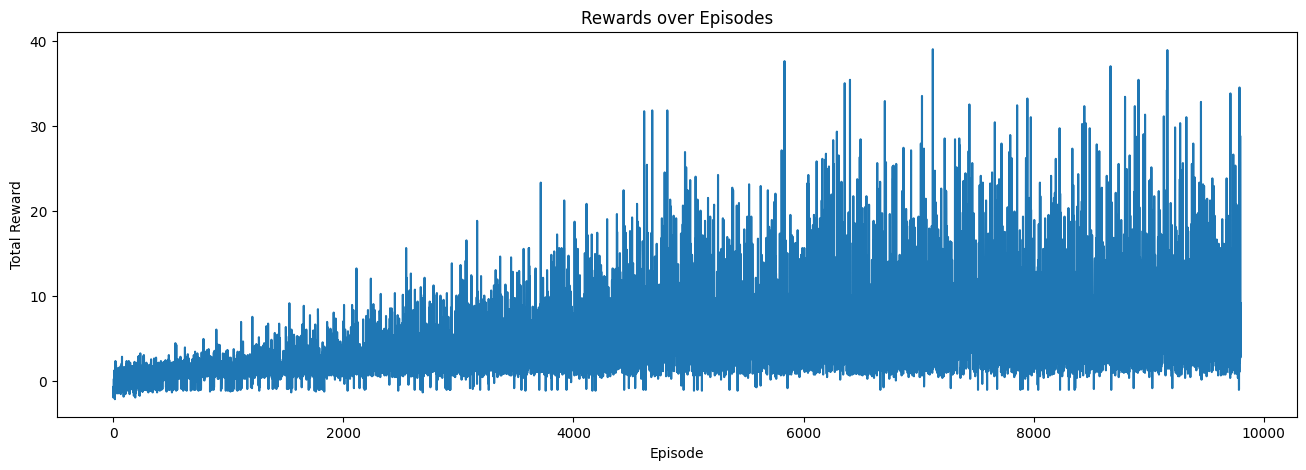

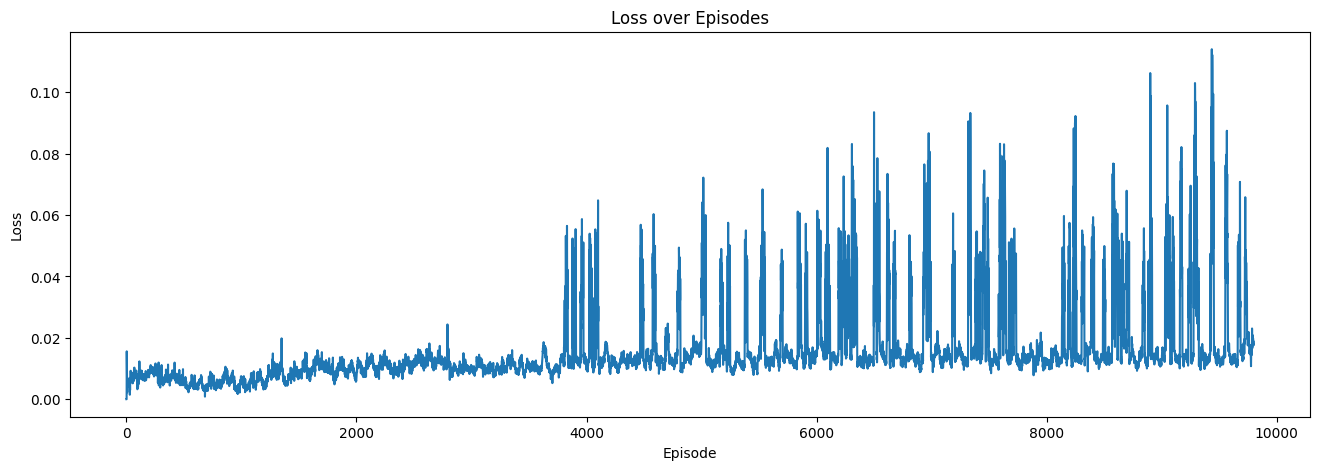

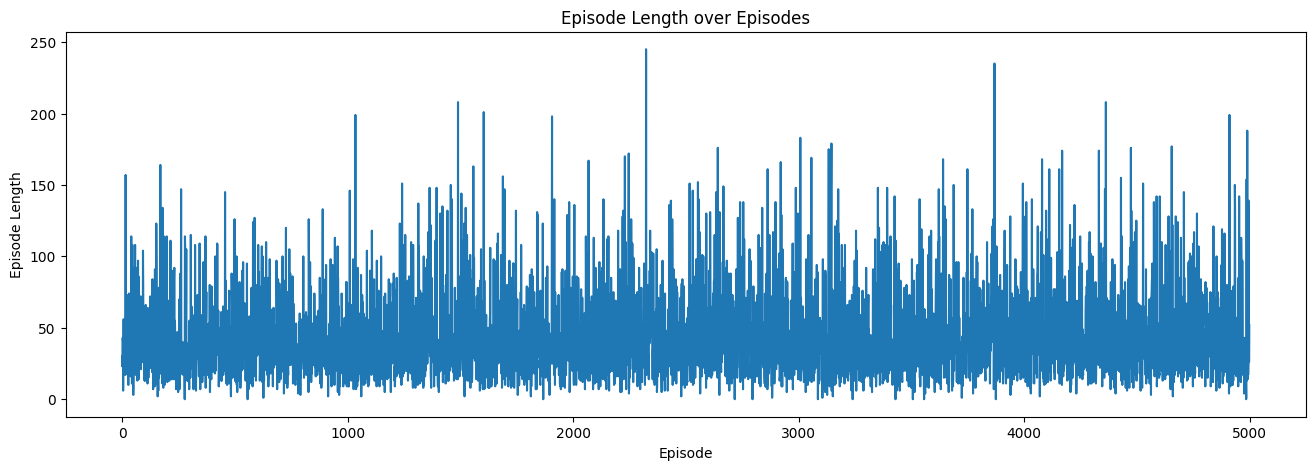

In [35]:

plt.figure(figsize=(16, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(lengths)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Length over Episodes')
plt.show()


Inference

In [39]:
env = UnityEnvironment(file_name="unity_builds/snake", seed=3, side_channels=[], no_graphics=False)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

# policy_net = DQN(n_observations, n_actions).to(device)
# policy_net = DuelingDQN(n_observations, n_actions).to(device)
# policy_net.load_state_dict(torch.load('weights/large_observations/4k/policy_net.pth'))
# policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
for t in range(5):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for i in range(STEPS):
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        if done or terminated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device)
env.close()

KeyboardInterrupt: 